# EYE FOR BLIND

### Objective

A deep learning model has to be created which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library.

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

In [1]:
#Import all the required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Embedding, concatenate, Dropout, Activation
from tensorflow.keras import Model
from tqdm import tqdm
import time
from PIL import Image

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
#Import the dataset and read the image into a seperate variable

images='archive/images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


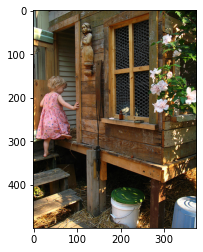

In [3]:
#Visualise both the images & text present in the dataset
plt.imshow(plt.imread(all_imgs[0]))
plt.show()

In [4]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    with open(filename) as f:
        text = f.read()
    return text

text_file = 'archive/captions.txt'
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Creating a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
all_img_id = [] 
all_img_vector = []
annotations = []

temp_df = pd.read_csv(text_file)
temp_df_dic = temp_df.to_dict('records')

for row in temp_df_dic:
    all_img_id.append(row['image'])
    all_img_vector.append(images+'/'+row['image'])
    annotations.append(row['caption'])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
print(df.shape)
df.head()

(40455, 3)


,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,archive/images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,archive/images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,archive/images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,archive/images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,archive/images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


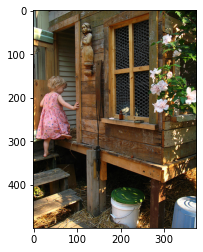

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


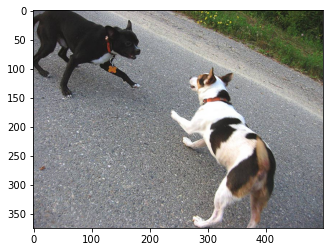

A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .


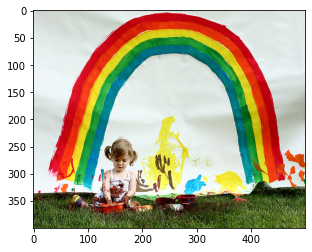

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [6]:
#Visualise both the images & text present in the dataset
for i in range(3):
    plt.imshow(plt.imread(all_imgs[i]))
    plt.show()
    for cap in df['Captions'].iloc[i*5:i*5+5]:
        print(cap)

In [7]:
annotations = ["<start> "+ x + " <end>" for x in df['Captions'].to_list()]#write your code here

all_img_path = df['Path'].unique().tolist() # taking unique images

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


- Each image has 5 captions hence, the captions are 5*8091 = 40455 in count and images are 8091

In [8]:
#vocabulary & the counter for the captions

vocabulary = [word for sentense in annotations for word in sentense.split()]#write your code here

val_count=Counter(vocabulary)
val_count

Counter({'<start>': 40455,
         'A': 22667,
         'child': 1477,
         'in': 18962,
         'a': 40319,
         'pink': 734,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1945,
         'entry': 1,
         'way': 50,
         '.': 36577,
         '<end>': 40455,
         'girl': 3218,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7984,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 772,
         'on': 10730,
         'road': 388,
         'white': 3876,
         'br

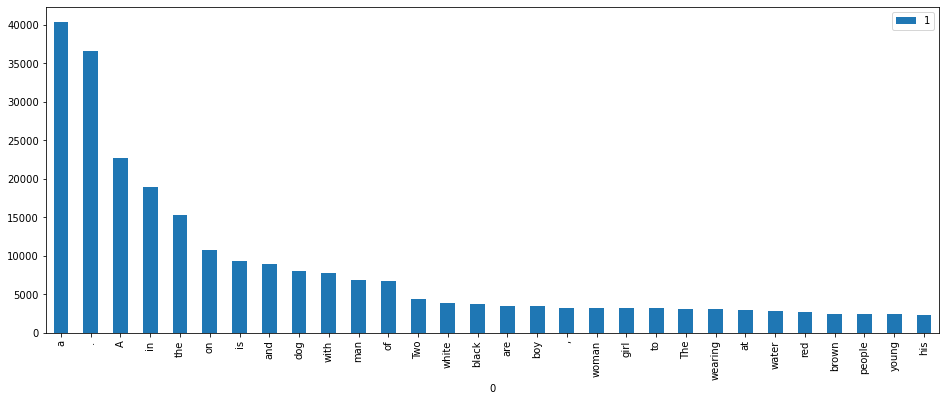

In [9]:
#top 30 occuring words in the captions

#Excluding <start> and <end> since it occurs in every annotation
pd.DataFrame(val_count.most_common(32)[2:]).set_index(0).plot.bar(figsize=(16,6))
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [10]:
#the tokenizer
tokenizer = Tokenizer(
    num_words=5001,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="<unk>",
    analyzer=None
)
tokenizer.fit_on_texts(annotations)

In [11]:
#word-to-index and index-to-word mappings.

# adding <pad> token to 0 index
tokenizer.word_index['<pad>']=0
tokenizer.index_word[0]='<pad>'


<AxesSubplot:xlabel='0'>

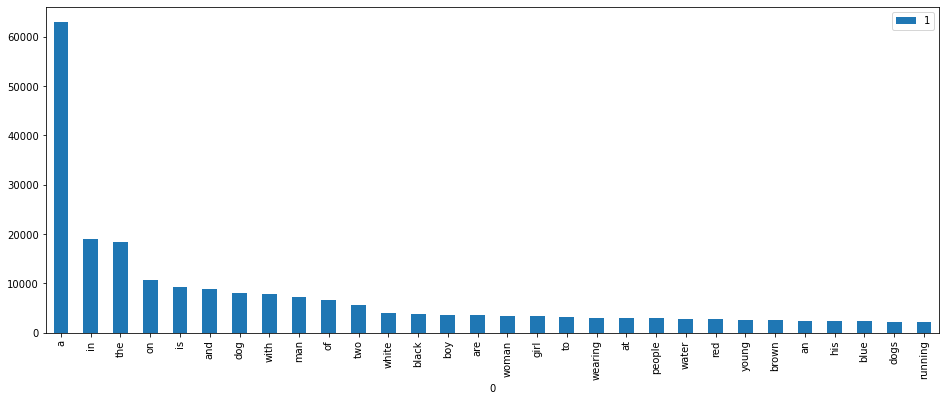

In [12]:
#word count of tokenizer to visulize the Top 30 occuring words after text processing

#Excluding <start> and <end> since it occurs in every annotation
pd.DataFrame(tokenizer.word_counts.items()).sort_values(1, ascending=False).iloc[:32].set_index(0).drop(['<start>', '<end>']).plot.bar(figsize=(16,6))

In [13]:
seq_lenghts = [len(seq.split()) for seq in annotations]
max_length = max(seq_lenghts)

cap_vector = pad_sequences(tokenizer.texts_to_sequences(annotations), maxlen=max_length, padding='post', truncating='post') #your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 40)


In [14]:
cap_vector[0]

array([  3,   2,  44,   5,   2,  91, 173,   8, 120,  52,   2, 394,  13,
       395,   5,  29,   1, 671,   4,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0])

In [15]:
tokenizer.sequences_to_texts(cap_vector[:1])

['<start> a child in a pink dress is climbing up a set of stairs in an <unk> way <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [16]:
all_img_path_tensor = tf.data.Dataset.from_tensor_slices(all_img_path)

In [17]:
def load_image(image_path):
    #write your pre-processing steps here
    
    img = tf.image.decode_jpeg(tf.io.read_file(image_path)) # Reading the images
    img = tf.image.resize(img, (299,299)) # resizing the images to (299, 299)
    img = tf.keras.applications.inception_v3.preprocess_input(img) # preprocessing as per inception_v3 input
    
    return img, image_path

In [18]:
batch_size = tf.data.AUTOTUNE
input_images = all_img_path_tensor.map(load_image).prefetch(buffer_size=batch_size).batch(32)

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [19]:
# Creating feature extractor model using inception_v3
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.inputs #write code here to get the input of the image_model
hidden_layer = image_model.outputs #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer) #build the final model using both input & output layer

In [20]:
def feature_extraction():
    path_features_dict = {}
    
    for path_img in input_images.as_numpy_iterator():
        imgs = path_img[0]
        paths = path_img[1]
        features = image_features_extract_model(imgs).numpy().reshape(-1, 8*8, 2048)
        for path, feature in zip(paths, features):
            path_features_dict[path] = feature
            
    return path_features_dict

# Extacting features and storing it to a dictionary
path_features_dict = feature_extraction()

In [21]:
# Checking shape of extracted feature
path_features_dict[b'archive/images/1000268201_693b08cb0e.jpg'].shape

(64, 2048)

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [22]:
path_train, path_test, cap_train, cap_test = train_test_split(df['Path'].to_list(), cap_vector, train_size=0.8, random_state=42)

In [23]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


['<start> woman with red crash helmet and native american tattoo on her arm <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']

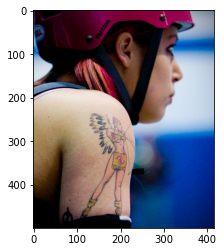

In [24]:
# Visualizing one of the datapoint from created train dataset
plt.imshow(plt.imread(path_train[3]))
tokenizer.sequences_to_texts(cap_train[3:4])

In [25]:
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_path, cap):
    img_tensor = path_features_dict[img_path.numpy()] # write your code here to extract the features from the dictionary stored earlier
    return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [26]:
batch_size = 32

def gen_dataset(img_paths, img_caps):
    AUTOTUNE = tf.data.AUTOTUNE 
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, img_caps)) # Creating tf dataset
    dataset = dataset.map(lambda x, y: tf.py_function(map_func, (x, y), [tf.float32, tf.int32])) # mapping image path to image features
    dataset = dataset.prefetch(AUTOTUNE).batch(batch_size)
    return dataset


In [27]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [28]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 40)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [29]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1

train_num_steps = len(path_train) // batch_size #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // batch_size #len(total test images) // BATCH_SIZE

### Encoder

In [30]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(embed_dim, activation='elu') #Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extracting the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

- Tried both relu and elu activation for dense layer of encoder
- Elu activation gave slightly better results over relu. Test loss was lower on last epoch when elu was used

In [31]:
encoder=Encoder(embedding_dim)

### Attention model

In [32]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        self.units = units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.reshape(hidden, (hidden.shape[0], 1, hidden.shape[1])) # Expanding the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(tf.math.tanh(self.W1(hidden_with_time_axis)+self.W2(features))) # building score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.math.softmax(score, axis=1) # extracting the attention weights with shape: (batch_size, 8*8, 1)
        context_vector = tf.math.multiply(features,attention_weights) #shape: creating the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, 1) # reducing the shape to (batch_size, embedding_dim)
        
        return context_vector, attention_weights

### Decoder

In [33]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention = Attention_model(self.units) #iniitalising Attention model with units
        self.embed = Embedding(vocab_size, embed_dim, input_length=max_length)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = Dense(self.units, activation='elu') 
        self.d2 = Dense(vocab_size)
        
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #creating your context vector & attention weights from attention model
        embed = self.embed(x) # embed input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.reshape(context_vector,(-1, 1, embedding_dim)), embed], 2) # Concatenating the input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extracting the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

- With and without Elu activation was tried out on dense d1 layer and found that elu had lower test loss compared to without activation

In [34]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [35]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, 1)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [36]:
optimizer = tf.optimizers.SGD(momentum=0.7) # define the optimizer
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True) #define your loss object

- Observed test loss of around 4 at last epoch of training when Adam was used as optimizer
- SGD optimizer gave lower test loss in the last epoch with almost similar train loss as Adam

In [37]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [38]:
checkpoint_path = "models/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for the model, Teacher forcing is applied.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [40]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1, target.shape[-1]):
            pred, hidden, at_w = decoder(dec_input, features, hidden)
            loss = loss + loss_function(target[:, i], pred)
            dec_input = tf.expand_dims(target[:, i], 1)
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    avg_loss = loss/target.shape[1]
    return loss, avg_loss

* While creating the test step for the model, previous prediciton will be passed as the next input to the decoder.

In [41]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    #write your code here to do the testing steps
    
    features = encoder(img_tensor)
    for i in range(1, target.shape[-1]):
        pred, hidden, at_w = decoder(dec_input, features, hidden)
        loss = loss + loss_function(target[:, i], pred)
        pred_ids = tf.argmax(tf.math.softmax(pred, axis=1), axis=1)
        dec_input = tf.expand_dims(pred_ids, 1)        
        
    avg_loss = loss/target.shape[1]
    return loss, avg_loss

In [42]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        
    avg_test_loss = total_loss / test_num_steps
    return avg_test_loss

In [43]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.201, & test loss is 2.840
Time taken for 1 epoch 219.0169382095337 sec

Test loss has been reduced from 100.000 to 2.840


  7%|█████▍                                                                            | 1/15 [03:39<51:14, 219.63s/it]

For epoch: 2, the train loss is 0.954, & test loss is 2.752
Time taken for 1 epoch 135.91802787780762 sec

Test loss has been reduced from 2.840 to 2.752


 13%|██████████▉                                                                       | 2/15 [05:56<37:00, 170.78s/it]

For epoch: 3, the train loss is 0.879, & test loss is 2.521
Time taken for 1 epoch 134.21675086021423 sec

Test loss has been reduced from 2.752 to 2.521


 27%|█████████████████████▊                                                            | 4/15 [10:25<26:51, 146.52s/it]

For epoch: 4, the train loss is 0.830, & test loss is 2.527
Time taken for 1 epoch 134.54380440711975 sec



 33%|███████████████████████████▎                                                      | 5/15 [12:40<23:43, 142.35s/it]

For epoch: 5, the train loss is 0.792, & test loss is 2.577
Time taken for 1 epoch 134.9410262107849 sec



 40%|████████████████████████████████▊                                                 | 6/15 [14:57<21:04, 140.55s/it]

For epoch: 6, the train loss is 0.761, & test loss is 2.576
Time taken for 1 epoch 137.05532693862915 sec



 47%|██████████████████████████████████████▎                                           | 7/15 [17:13<18:31, 138.91s/it]

For epoch: 7, the train loss is 0.732, & test loss is 2.601
Time taken for 1 epoch 135.54396677017212 sec



 53%|███████████████████████████████████████████▋                                      | 8/15 [19:27<16:02, 137.50s/it]

For epoch: 8, the train loss is 0.706, & test loss is 2.616
Time taken for 1 epoch 134.4796600341797 sec



 60%|█████████████████████████████████████████████████▏                                | 9/15 [21:43<13:41, 136.95s/it]

For epoch: 9, the train loss is 0.686, & test loss is 2.680
Time taken for 1 epoch 135.73104572296143 sec



 67%|██████████████████████████████████████████████████████                           | 10/15 [23:59<11:22, 136.59s/it]

For epoch: 10, the train loss is 0.663, & test loss is 2.720
Time taken for 1 epoch 135.78387689590454 sec



 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [26:13<09:03, 135.90s/it]

For epoch: 11, the train loss is 0.642, & test loss is 2.777
Time taken for 1 epoch 134.32321214675903 sec



 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [28:27<06:46, 135.48s/it]

For epoch: 12, the train loss is 0.626, & test loss is 2.784
Time taken for 1 epoch 134.53373980522156 sec



 87%|██████████████████████████████████████████████████████████████████████▏          | 13/15 [30:42<04:30, 135.21s/it]

For epoch: 13, the train loss is 0.685, & test loss is 2.817
Time taken for 1 epoch 134.59167408943176 sec



 93%|███████████████████████████████████████████████████████████████████████████▌     | 14/15 [32:56<02:14, 134.98s/it]

For epoch: 14, the train loss is 0.626, & test loss is 2.815
Time taken for 1 epoch 134.44076323509216 sec



100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [35:16<00:00, 141.09s/it]

For epoch: 15, the train loss is 0.596, & test loss is 2.836
Time taken for 1 epoch 139.34158849716187 sec



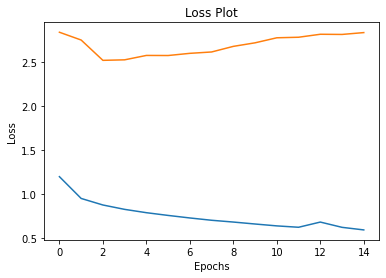

In [44]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [45]:
attention_features_shape = 64

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extracting features using feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extracting the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        # Applying softmax to get probabilty scores
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=1), axis=1).numpy()[0]  
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


### Beam Search(optional)

In [46]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    max_length = 40
    
    result = [[[tokenizer.word_index['<start>']], 0.0]*beam_index]
    hidden = [decoder.init_state(batch_size=1)]*beam_index

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)

    for l in range(max_length):
        temp = []
        for i, caption in enumerate(result):

            dec_input = tf.expand_dims([caption[0][-1]], 0)  
            
            predictions, hidden[i], attention_weights = decoder(dec_input, features, hidden[i])

            word_preds = np.argsort(predictions[0])[-beam_index:]

            for word_id in word_preds:
                
                cap, prob = caption[0][:], caption[1]
                cap.append(word_id)
                prob *= np.log(predictions[0][word_id]) # Conditional probability
                temp.append([cap, prob])
                
        result = temp
        result = sorted(result, key=lambda l: l[1])
        result = result[-beam_index:]

    caption = [tokenizer.index_word[c] for c in result[-1][0]]

    final_caption = []
    
    for i in caption:
        if i != '<end>':
            final_caption.append(i) 
        else:
            break

    final_caption = ' '.join(final_caption[1:])

    return final_caption



In [47]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.Resampling.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [48]:
from nltk.translate.bleu_score import sentence_bleu

In [49]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [50]:
import warnings
warnings.filterwarnings('ignore')

BELU score: 24.593613259204204
Real Caption: a girl in a white dress on the beach
Prediction Caption: a woman stands on the beach


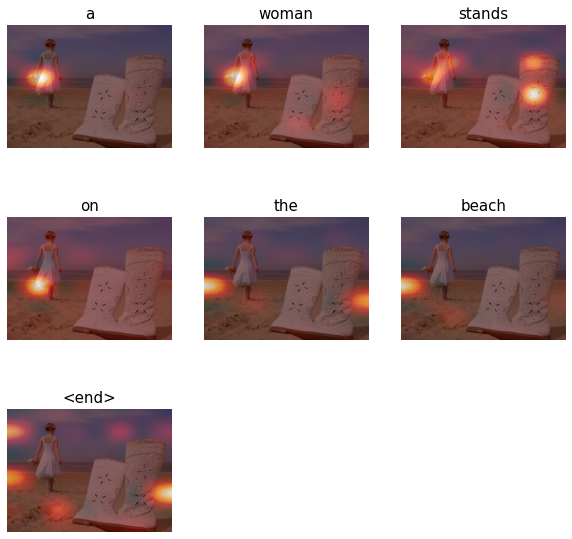

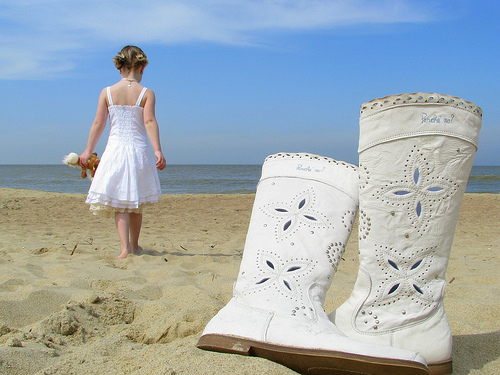

In [67]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]

# test_image = './archive/images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)     

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

weights = (1./3, 1./3, 1./3)
score = sentence_bleu(reference, candidate, weights=weights) 
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [68]:
captions=beam_evaluate(test_image)
print(captions)
print(sentence_bleu(reference, captions.split(), weights=weights)*100)

a girl stands on the beach
30.326532985631673


In [69]:
from gtts import gTTS
from IPython import display

language = 'en'
tts = gTTS(pred_caption, lang=language, slow = False)
tts.save('caption.mp3')

sound_file = 'caption.mp3'
display.display(display.Audio(sound_file))

In [70]:
# Taking average bleu scores for 100 test images
for z in range(100):
    
    test_image = path_test[z]
    scores_greedy = []
    scores_beam = []
    
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[z] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)     
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    captions=beam_evaluate(test_image)
    weights = (1./3, 1./3, 1./3)
    scores_greedy.append(sentence_bleu(reference, candidate, weights=weights))
    scores_beam.append(sentence_bleu(reference, captions.split(), weights=weights))
    
print('Average bleu score for greedy search', np.mean(scores_greedy)*100)
print('Average bleu score for beam search', np.mean(scores_beam)*100)

Average bleu score for greedy search 27.43448438319475
Average bleu score for beam search 23.04944801014416


- Model is doing a decent predictions
- Running for higher number of epoch, using word2vec for embbedings and changing neurons in dense layers can improve the model performance